## Feature Engineering 2: Dimensionality and PCA 
### US Education dataset

In [24]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')

### Upload data from sql

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'useducation'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

useducation_df = pd.read_sql_query('select * from useducation',con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

In [3]:
useducation_df.head()

,PRIMARY_KEY,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,...,GRADES_4_G,GRADES_8_G,GRADES_12_G,GRADES_1_8_G,GRADES_9_12_G,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE
0,1992_ALABAMA,ALABAMA,1992,NaN,2678885.0,304177.0,1659028.0,715680.0,2653798.0,1481703.0,...,57948.0,58025.0,41167.0,471564.0,196386.0,676174.0,208.327876,252.187522,207.963517,NaN
1,1992_ALASKA,ALASKA,1992,NaN,1049591.0,106780.0,720711.0,222100.0,972488.0,498362.0,...,9748.0,8789.0,6714.0,79117.0,30847.0,112335.0,NaN,NaN,NaN,258.859712
2,1992_ARIZONA,ARIZONA,1992,NaN,3258079.0,297888.0,1369815.0,1590376.0,3401580.0,1435908.0,...,55433.0,49081.0,37410.0,437127.0,175210.0,614881.0,215.253932,265.366278,206.212716,262.169895
3,1992_ARKANSAS,ARKANSAS,1992,NaN,1711959.0,178571.0,958785.0,574603.0,1743022.0,964323.0,...,34632.0,36011.0,27651.0,281338.0,123113.0,405259.0,210.206028,256.312090,208.634458,264.619665
4,1992_CALIFORNIA,CALIFORNIA,1992,NaN,26260025.0,2072470.0,16546514.0,7641041.0,27138832.0,14358922.0,...,418418.0,363296.0,270675.0,3286034.0,1372011.0,4717112.0,208.398961,260.892247,196.764414,NaN


In [30]:
useducation_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1046 entries, 54 to 1491
Data columns (total 26 columns):
PRIMARY_KEY                     1046 non-null object
STATE                           1046 non-null object
YEAR                            1046 non-null int64
ENROLL                          1046 non-null float64
TOTAL_REVENUE                   1046 non-null float64
FEDERAL_REVENUE                 1046 non-null float64
STATE_REVENUE                   1046 non-null float64
LOCAL_REVENUE                   1046 non-null float64
TOTAL_EXPENDITURE               1046 non-null float64
INSTRUCTION_EXPENDITURE         1046 non-null float64
SUPPORT_SERVICES_EXPENDITURE    1046 non-null float64
OTHER_EXPENDITURE               1046 non-null float64
CAPITAL_OUTLAY_EXPENDITURE      1046 non-null float64
GRADES_PK_G                     1046 non-null float64
GRADES_KG_G                     1046 non-null float64
GRADES_4_G                      1046 non-null float64
GRADES_8_G                      

### Fill in missing data

In [16]:
columns = useducation_df.columns

states = useducation_df["STATE"].unique()

for state in states:
    useducation_df.loc[useducation_df['STATE'] == state, columns[3:]] \
            = useducation_df.loc[useducation_df["STATE"] == state, columns[3:]].interpolate()
    
useducation_df.dropna(inplace=True)

In [19]:
useducation_df.head()

,PRIMARY_KEY,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,...,GRADES_4_G,GRADES_8_G,GRADES_12_G,GRADES_1_8_G,GRADES_9_12_G,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE
54,1993_ARIZONA,ARIZONA,1993,676297.0,3427976.0,318465.0,1415407.0,1694104.0,3623946.0,1578889.0,...,57701.0,53500.0,37614.0,461398.0,182737.0,647299.0,215.834434,265.993417,206.291984,262.448330
55,1993_ARKANSAS,ARKANSAS,1993,311432.0,1346909.0,128196.0,771079.0,447634.0,1376067.0,782791.0,...,34255.0,36471.0,27169.0,280280.0,125801.0,407329.0,211.616130,257.647254,208.685273,266.423396
57,1993_COLORADO,COLORADO,1993,539538.0,3058326.0,147793.0,1242337.0,1668196.0,3028305.0,1537714.0,...,50807.0,47665.0,34770.0,403871.0,164260.0,575380.0,222.219036,273.200878,215.523979,266.856804
58,1993_CONNECTICUT,CONNECTICUT,1993,471918.0,4064158.0,149204.0,1433539.0,2481415.0,4079943.0,2302852.0,...,39093.0,34662.0,27979.0,310022.0,127655.0,443893.0,228.105503,275.202320,224.712775,264.457874
59,1993_DELAWARE,DELAWARE,1993,104355.0,683954.0,44497.0,443250.0,196207.0,694534.0,394680.0,...,8285.0,8265.0,5882.0,67899.0,28930.0,97394.0,217.181255,263.834857,207.792430,262.255809


### Question 1

Create a new score variable from the weighted averages of all score variables in the datasets. Notice that the number of students in the 4th grade isn't the same as the number of students in the 8th grade. So, you should appropriately weigh the scores!.

In [20]:
useducation_df["overall_score"] = (useducation_df["GRADES_4_G"]*((useducation_df["AVG_MATH_4_SCORE"] + useducation_df["AVG_READING_4_SCORE"])*0.5) \
                                    + useducation_df["GRADES_8_G"]*((useducation_df["AVG_MATH_8_SCORE"] + useducation_df["AVG_READING_8_SCORE"])*0.5)) \
                                            /(useducation_df["GRADES_4_G"] + useducation_df["GRADES_8_G"])

# {total 4th grade students * (ave math score + ave reading score * 0.5)} + {total 8th grade students * (ave math score + ave reading score * 0.5)}
# _____________
# (total 4th graders + total 8th graders)



In [21]:
useducation_df.head()

,PRIMARY_KEY,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,...,GRADES_8_G,GRADES_12_G,GRADES_1_8_G,GRADES_9_12_G,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE,overall_score
54,1993_ARIZONA,ARIZONA,1993,676297.0,3427976.0,318465.0,1415407.0,1694104.0,3623946.0,1578889.0,...,53500.0,37614.0,461398.0,182737.0,647299.0,215.834434,265.993417,206.291984,262.448330,236.637935
55,1993_ARKANSAS,ARKANSAS,1993,311432.0,1346909.0,128196.0,771079.0,447634.0,1376067.0,782791.0,...,36471.0,27169.0,280280.0,125801.0,407329.0,211.616130,257.647254,208.685273,266.423396,236.905842
57,1993_COLORADO,COLORADO,1993,539538.0,3058326.0,147793.0,1242337.0,1668196.0,3028305.0,1537714.0,...,47665.0,34770.0,403871.0,164260.0,575380.0,222.219036,273.200878,215.523979,266.856804,243.634022
58,1993_CONNECTICUT,CONNECTICUT,1993,471918.0,4064158.0,149204.0,1433539.0,2481415.0,4079943.0,2302852.0,...,34662.0,27979.0,310022.0,127655.0,443893.0,228.105503,275.202320,224.712775,264.457874,246.815311
59,1993_DELAWARE,DELAWARE,1993,104355.0,683954.0,44497.0,443250.0,196207.0,694534.0,394680.0,...,8265.0,5882.0,67899.0,28930.0,97394.0,217.181255,263.834857,207.792430,262.255809,237.735539


### Question 2

What are the correlations between this newly created score variable and the expenditure types? Which 1 of the expenditure types is more correlated than the others?

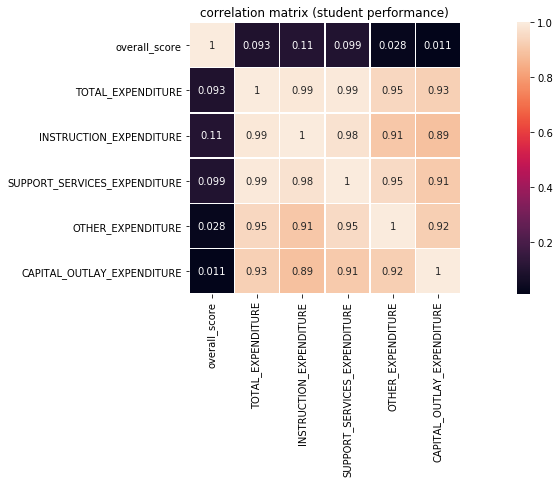

In [23]:
corrmat_student = useducation_df[["overall_score", "TOTAL_EXPENDITURE", "INSTRUCTION_EXPENDITURE",
                  "SUPPORT_SERVICES_EXPENDITURE", "OTHER_EXPENDITURE", "CAPITAL_OUTLAY_EXPENDITURE"]].corr()

plt.figure(figsize=(20,5))

sns.heatmap(corrmat_student, square=True, annot=True, linewidths=.5)
plt.title("correlation matrix (student performance)")

plt.show()

Instruction expenditure is most correlated with overall score

### Question 3

Now, apply PCA to the 4 expenditure types. How much of the total variance is explained by the 1st component?

In [31]:
X = useducation_df[["INSTRUCTION_EXPENDITURE", "SUPPORT_SERVICES_EXPENDITURE",
                      "OTHER_EXPENDITURE", "CAPITAL_OUTLAY_EXPENDITURE"]]

X = StandardScaler().fit_transform(X)

sklearn_pca = PCA(n_components=1)
useducation_df["pca_1"] = sklearn_pca.fit_transform(X)

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.94568116]


### Question 4

What is the correlation between the overall score variable and the 1st principal component?

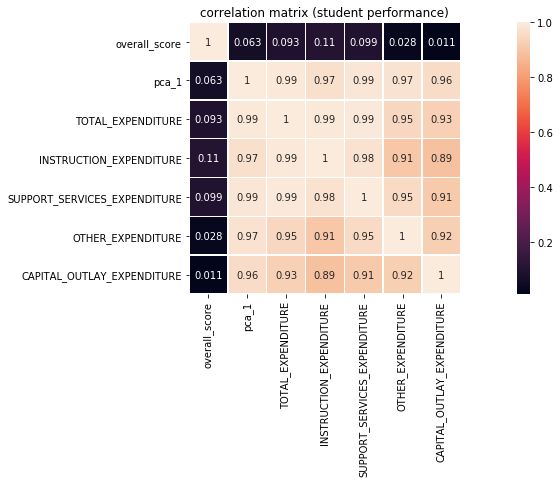

In [33]:
corrmat_student = useducation_df[["overall_score", "pca_1", "TOTAL_EXPENDITURE", "INSTRUCTION_EXPENDITURE",
              "SUPPORT_SERVICES_EXPENDITURE", "OTHER_EXPENDITURE", "CAPITAL_OUTLAY_EXPENDITURE"]].corr()

plt.figure(figsize=(20,5))

sns.heatmap(corrmat_student, square=True, annot=True, linewidths=.5)
plt.title("correlation matrix (student performance)")

plt.show()

### Question 5


If you were to choose the best variables for your model, would you prefer using the 1st principal component instead of the expenditure variables? Why?

Instruction and support show better correlations.